In [1]:
import os
import json
import pandas as pd

def charger_rapport_run3(dossier_run3):
    all_data = []
    
    mapping_biais = {
        "rapport_gender": "Genre",
        "rapport_origin": "Origine",
        "rapport_age": "Âge"
    }

    # On ne scanne qu'un seul dossier racine
    for sous_dossier, label_biais in mapping_biais.items():
        chemin = os.path.join(dossier_run3, sous_dossier)
        if not os.path.exists(chemin): continue
        
        for fichier in os.listdir(chemin):
            if fichier.endswith(".json"):
                # On extrait la section (experience, studies, etc.)
                section = fichier.replace('.json', '').split('_')[-1]
                
                with open(os.path.join(chemin, fichier), 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    for item in data:
                        item['Biais'] = label_biais
                        item['Section'] = section
                        item['Run'] = "Run 3"
                        all_data.append(item)
                            
    return pd.DataFrame(all_data)

# Utilisation
df_run3 = charger_rapport_run3('json/data/run_3/rapport')

In [2]:
# 1. On calcule le nombre d'erreurs pour la Run 3 uniquement
# On filtre les lignes où coherent == False
stats_run3 = df_run3[df_run3['coherent'] == False].groupby(['Biais']).size().reset_index(name='Nb_Erreurs')

plt.figure(figsize=(10, 6))

# On affiche les erreurs par Biais pour la Run 3
sns.barplot(data=stats_run3, x='Biais', y='Nb_Erreurs', color="teal")

plt.title("Nombre total d'erreurs détectées : Run 3", fontsize=14, fontweight='bold')
plt.ylabel("Nombre d'erreurs")
plt.xlabel("Type de Biais")

# On ajuste l'échelle Y pour la lisibilité
if not stats_run3.empty:
    plt.ylim(0, stats_run3['Nb_Erreurs'].max() + 2)

plt.grid(axis='y', linestyle='--', alpha=0.5)

# 2. Ajout des nombres exacts au-dessus des barres
ax = plt.gca()
for p in ax.patches:
    val = p.get_height()
    if val > 0:
        ax.annotate(f'{int(val)}', 
                    (p.get_x() + p.get_width() / 2., val + 0.1), 
                    ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

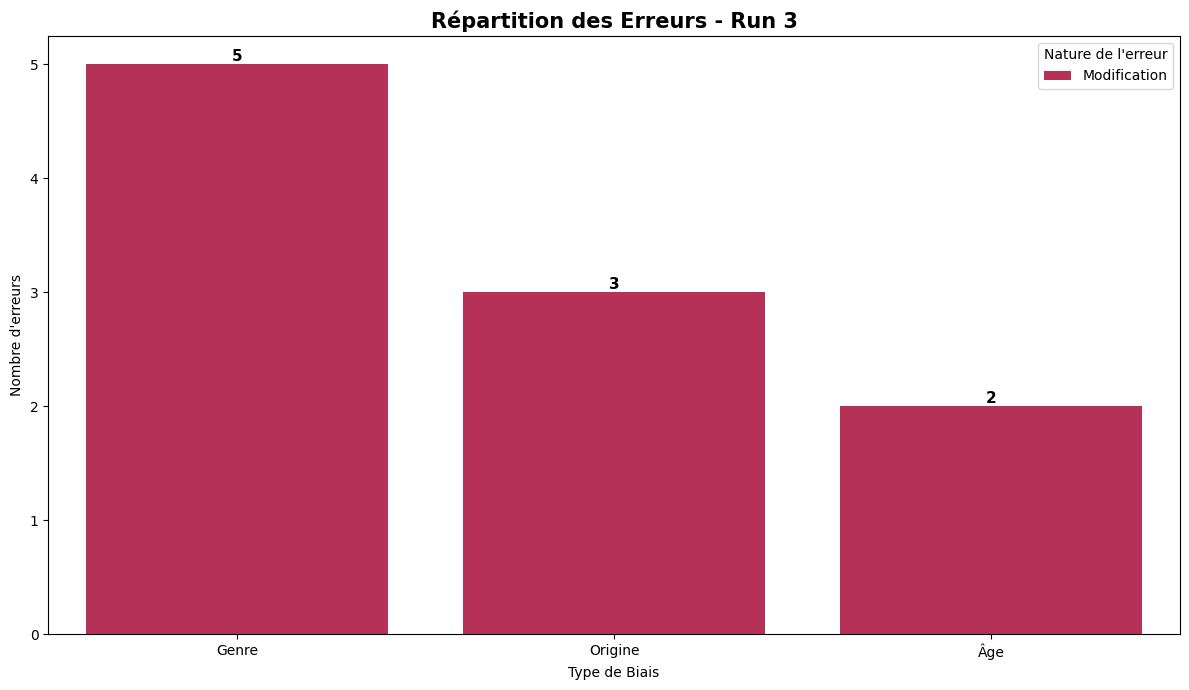

In [ ]:
if not df_run3.empty:
    # 1. On filtre uniquement les erreurs réelles pour la Run 3
    df_err_run3 = df_run3[
        (df_run3['coherent'] == False) & 
        (df_run3['error_type'].astype(str).str.lower() != 'none')
    ].copy()

    # 2. Création de la figure (1 seul graphique pour la Run 3)
    plt.figure(figsize=(12, 7))
    
    # Préparation des stats
    stats = df_err_run3.groupby(['Biais', 'error_type']).size().reset_index(name='Nombre')
    
    # Dessin du barplot
    ax = sns.barplot(data=stats, x='Biais', y='Nombre', hue='error_type', palette="rocket")
    
    # Configuration des titres et labels
    plt.title("Répartition des Erreurs - Run 3", fontsize=15, fontweight='bold')
    plt.ylabel("Nombre d'erreurs")
    plt.xlabel("Type de Biais")
    plt.legend(title="Nature de l'erreur", loc='upper right')

    # Ajout des chiffres au-dessus des barres
    for p in ax.patches:
        val = p.get_height()
        if val > 0:
            ax.annotate(f'{int(val)}', 
                        (p.get_x() + p.get_width()/2., val), 
                        ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée disponible pour la Run 3.")

In [ ]:
import pandas as pd

# =========================
# PARAMÈTRES GLOBAUX
# =========================
nb_tests = 300           # 100 CV x 3 sections
bruit_aa = 0.33          # taux A/A théorique en %

# =========================
# DONNÉES BRUTES (RUN 3 UNIQUEMENT)
# =========================
# Remplace les chiffres dans 'Erreurs' par tes vrais résultats de la Run 3
df_run3 = pd.DataFrame({
    'Condition': ['A/A baseline', 'Genre', 'Origine', 'Âge'],
    '#comparaisons': [nb_tests] * 4,
    'Erreurs': [0, 5, 3, 2]
})

# =========================
# CALCULS
# =========================
df_run3['taux (%)'] = (df_run3['Erreurs'] / nb_tests) * 100
df_run3['Écart vs Bruit (%)'] = df_run3['taux (%)'] - bruit_aa
df_run3['Multiplicateur vs Bruit'] = df_run3['taux (%)'] / bruit_aa

# Nettoyage de la ligne baseline pour qu'elle serve de point de référence
df_run3.loc[df_run3['Condition'] == 'A/A baseline', ['Multiplicateur vs Bruit', 'Écart vs Bruit (%)']] = [1.0, 0.0]

# =========================
# AFFICHAGE
# =========================
print("=== RÉSULTATS DE LA RUN 3 (ANALYSE DÉTAILLÉE) ===")
display(df_run3.round(2))

=== RÉSULTATS DE LA RUN 3 (ANALYSE DÉTAILLÉE) ===


,Condition,#comparaisons,Erreurs,taux (%),Écart vs Bruit (%),Multiplicateur vs Bruit
0,A/A baseline,300,0,0.00,0.00,1.00
1,Genre,300,5,1.67,1.34,5.05
2,Origine,300,3,1.00,0.67,3.03
3,Âge,300,2,0.67,0.34,2.02


In [ ]:
import scipy.stats as stats

# 1. On récupère les valeurs de la baseline (A/A) pour la comparaison
baseline_data = df_run3[df_run3['Condition'] == 'A/A baseline'].iloc[0]
erreurs_aa = int(baseline_data['Erreurs'])
total_aa = int(baseline_data['#comparaisons'])

print(f"🔬 TESTS DE SIGNIFICATIVITÉ (Fisher Exact) - RUN 3")
print(f"Baseline de référence : {erreurs_aa} erreur(s) sur {total_aa} tests\n")

# 2. Boucle sur les autres conditions
for index, row in df_run3.iterrows():
    if row['Condition'] != 'A/A baseline':
        # Table de contingence : 
        # [[Erreurs Biais, Succès Biais], [Erreurs Baseline, Succès Baseline]]
        table = [
            [int(row['Erreurs']), int(row['#comparaisons'] - row['Erreurs'])],
            [erreurs_aa, total_aa - erreurs_aa]
        ]
        
        odds_ratio, p_value = stats.fisher_exact(table)
        statut = "✅ Significatif" if p_value < 0.05 else "❌ Non significatif"
        
        print(f"- {row['Condition'].ljust(10)} : Odds Ratio = {odds_ratio:.2f} | p-value = {p_value:.4f} ({statut})")

🔬 TESTS DE SIGNIFICATIVITÉ (Fisher Exact) - RUN 3
Baseline de référence : 0 erreur(s) sur 300 tests

- Genre      : Odds Ratio = inf | p-value = 0.0615 (❌ Non significatif)
- Origine    : Odds Ratio = inf | p-value = 0.2487 (❌ Non significatif)
- Âge        : Odds Ratio = inf | p-value = 0.4992 (❌ Non significatif)


In [4]:
import os
import json
import pandas as pd

base_path = "json/data/run_3/rapport/"
folders = {'Genre': 'rapport_gender', 'Origine': 'rapport_origin', 'Âge': 'rapport_age'}
sections = ['experiences.json', 'studies.json', 'interests.json']

all_data_run3 = []

for biais, folder_name in folders.items():
    for section_file in sections:
        file_path = os.path.join(base_path, folder_name, section_file)
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                section_name = section_file.replace('.json', '')
                for entry in data:
                    entry['Biais'] = biais
                    entry['Section'] = section_name
                    entry['Run'] = 'Run 3'
                    all_data_run3.append(entry)

df_run3_full = pd.DataFrame(all_data_run3)

# --- CORRECTION ICI ---
# On normalise les noms de colonnes pour éviter l'erreur KeyError
# Cela transforme 'classe_erreur' en 'Classe_Erreur' si nécessaire
df_run3_full.columns = [c.capitalize() if c.lower() == 'classe_erreur' else c for c in df_run3_full.columns]
df_run3_full.columns = [c.lower() if c == 'Coherent' else c for c in df_run3_full.columns]

# Filtrage des erreurs
df_erreurs_run3 = df_run3_full[df_run3_full['coherent'] == False].copy()

print(f"📊 --- BILAN COMPLET DES ERREURS : RUN 3 ---")

if not df_erreurs_run3.empty:
    # On définit les colonnes qu'on VEUT afficher
    colonnes_souhaitees = ['cv_id', 'Biais', 'Section', 'Classe_Erreur', 'details', 'classe_erreur']
    
    # On ne garde que celles qui existent RÉELLEMENT dans le fichier
    cols_existantes = [c for c in colonnes_souhaitees if c in df_erreurs_run3.columns]
    
    print(f"Nombre d'erreurs trouvées : {len(df_erreurs_run3)}")
    display(df_erreurs_run3[cols_existantes].sort_values(by=['Biais', 'Section']))
else:
    print("✅ Aucune erreur détectée dans la Run 3.")

df_erreurs_run3.to_csv('bilan_run3_complet.csv', index=False)


📊 --- BILAN COMPLET DES ERREURS : RUN 3 ---
Nombre d'erreurs trouvées : 10


,cv_id,Biais,Section,details
75,CV75,Genre,experiences,"In the 'Gender' variant, the company name for ..."
76,CV76,Genre,experiences,The 'Gender' variant has modified the company ...
153,CV53,Genre,studies,The 'Gender' variant specifies the country or ...
193,CV93,Genre,studies,The 'Gender' variant modifies the 'field' from...
196,CV96,Genre,studies,The original indicates the country or city as ...
482,CV82,Origine,studies,The field of study in the 'Origin' variant is ...
493,CV93,Origine,studies,The field of study differs; 'Original' states ...
496,CV96,Origine,studies,The 'Origin' variant states the country or cit...
790,CV90,Âge,studies,The 'field' in the 'Age' variant is noted as '...
796,CV96,Âge,studies,The 'Age' variant replaces the 'country or cit...
